### Make sure desired packages are installed with pip

In [1]:
!pip install metpy
!pip install netCDF4
!pip install siphon

from datetime import datetime, timedelta
from netCDF4 import Dataset, num2date
from calendar import monthrange
from datetime import datetime
import itertools

from netCDF4 import date2num, num2date
import numpy as np
from pyproj import Proj
from siphon.catalog import TDSCatalog
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import folium
import os

  Using cached MetPy-1.0.1-py3-none-any.whl (330 kB)
  Using cached importlib_resources-5.2.0-py3-none-any.whl (27 kB)
  Using cached Pint-0.17-py2.py3-none-any.whl (204 kB)
  Using cached pooch-1.4.0-py3-none-any.whl (51 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached xarray-0.18.2-py3-none-any.whl (807 kB)
  Using cached netCDF4-1.5.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached cftime-1.5.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (222 kB)
  Using cached siphon-0.9-py2.py3-none-any.whl (69 kB)


# Query

In [4]:

# Spatial location to find stuff
lats = np.linspace(68.5,70,5)
lons = np.linspace(-135.5,-134,5)

print(lats, lons)

years = np.arange(2000,2020)
months = np.arange(6,10)
Subsurface_fields = ['tsoil','soilw']
Surface_fields = ['air.2m','uwnd.10m','vwnd.10m',#'pres.sfc',
#                   'dswrf','dlwrf','uswrf.ntat','ulwrf.ntat',
                  'apcp',#,'tcdc','hpbl',
                  'rhum.2m'
                 ]
clear = False

Dir = 'Data/Subsurface/'
if clear == True:
    for i,dsname in enumerate(os.listdir(Dir)):
        os.remove(Dir+dsname)
        
base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/subsurface/catalog.xml'
main_cat = TDSCatalog(base_catalog)

for year, month, varname in itertools.product(years, months,Subsurface_fields):
    
    dsname = '{}.{:4d}{:02d}.nc'.format(varname, year, month)
    if os.path.isfile(Dir+dsname)==False: 
    
        print('{}: downloading...'.format(dsname), end='')

        # Grab it using opendap--manually convert to CF to work around the
        # fact that missing_value and _FillValue differ
        ds = xr.open_dataset(main_cat.datasets[dsname].access_urls['OPENDAP'],
                             decode_cf=False)
        ds = xr.conventions.decode_cf(ds, mask_and_scale=False)

        # Grab the projection variable and convert our points to that
        # Probably not strictly necessary
        var = varname.split('.')[0]
        proj_var = ds[ds[var].grid_mapping]
        proj = Proj(proj='lcc', lat_0=proj_var.latitude_of_projection_origin,
                lon_0=proj_var.longitude_of_central_meridian,
                lat_1=proj_var.standard_parallel[0],
                lat_2=proj_var.standard_parallel[1],
                x_0=proj_var.false_easting, y_0=proj_var.false_northing,
                ellps='sphere')
        x, y = proj(lons, lats)
        # Subset the data
        print('subsetting...', end='')
    #     ds.
        pt_ds = ds.sel(x=x, y=y, method='nearest')
        print('saving...', end='')

        # Save to disk
        pt_ds.to_netcdf(Dir+dsname)
        print('done.')

Dir = 'Data/Surface/'
if clear == True:
    for i,dsname in enumerate(os.listdir(Dir)):
        os.remove(Dir+dsname)
    
base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/monolevel/catalog.xml'
main_cat = TDSCatalog(base_catalog)

for year, varname in itertools.product(years,Surface_fields):
#     # Figure out what to grab
    dsname = '{}.{:4d}.nc'.format(varname, year)
    
    if os.path.isfile(Dir+dsname)==False: 


        print('{}: downloading...'.format(dsname), end='')

        # Grab it using opendap--manually convert to CF to work around the
        # fact that missing_value and _FillValue differ
        ds = xr.open_dataset(main_cat.datasets[dsname].access_urls['OPENDAP'],
                             decode_cf=False)
        ds = xr.conventions.decode_cf(ds, mask_and_scale=False)

        # Grab the projection variable and convert our points to that
        # Probably not strictly necessary
        var = varname.split('.')[0]
        proj_var = ds[ds[var].grid_mapping]
        proj = Proj(proj='lcc', lat_0=proj_var.latitude_of_projection_origin,
                lon_0=proj_var.longitude_of_central_meridian,
                lat_1=proj_var.standard_parallel[0],
                lat_2=proj_var.standard_parallel[1],
                x_0=proj_var.false_easting, y_0=proj_var.false_northing,
                ellps='sphere')
        x, y = proj(lons, lats)
        # Subset the data
        print('subsetting...', end='')
    #     ds.
        pt_ds = ds.sel(x=x, y=y, method='nearest')
        print('saving...', end='')

        # Save to disk
        pt_ds.to_netcdf(Dir+dsname)
        print('done.')

[68.5   68.875 69.25  69.625 70.   ] [-135.5   -135.125 -134.75  -134.375 -134.   ]
rhum.2m.2000.nc: downloading...subsetting...saving...done.
rhum.2m.2001.nc: downloading...subsetting...saving...done.
rhum.2m.2002.nc: downloading...subsetting...saving...done.
rhum.2m.2003.nc: downloading...subsetting...saving...done.
rhum.2m.2004.nc: downloading...subsetting...saving...done.
rhum.2m.2005.nc: downloading...subsetting...saving...done.
rhum.2m.2006.nc: downloading...subsetting...saving...done.
rhum.2m.2007.nc: downloading...subsetting...saving...done.
rhum.2m.2008.nc: downloading...subsetting...saving...done.
rhum.2m.2009.nc: downloading...subsetting...saving...done.
rhum.2m.2010.nc: downloading...subsetting...saving...done.
rhum.2m.2011.nc: downloading...subsetting...saving...done.
rhum.2m.2012.nc: downloading...subsetting...saving...done.
rhum.2m.2013.nc: downloading...subsetting...saving...done.
rhum.2m.2014.nc: downloading...subsetting...saving...done.
rhum.2m.2015.nc: downloading...

# IDW

0
tsoil.201407.nc
tsoil.201709.nc
tsoil.200806.nc
soilw.200308.nc
soilw.200006.nc
tsoil.201308.nc
tsoil.201006.nc
soilw.201806.nc
soilw.200407.nc
soilw.200709.nc
soilw.201807.nc
soilw.200708.nc
soilw.200406.nc
tsoil.201007.nc
tsoil.201309.nc
soilw.200007.nc
soilw.200309.nc
tsoil.201708.nc
tsoil.201406.nc
tsoil.200807.nc
tsoil.201806.nc
tsoil.200407.nc
tsoil.200709.nc
soilw.201308.nc
soilw.201006.nc
tsoil.200308.nc
tsoil.200006.nc
soilw.201407.nc
soilw.201709.nc
soilw.200806.nc
soilw.201708.nc
soilw.201406.nc
soilw.200807.nc
tsoil.200007.nc
tsoil.200309.nc
soilw.201007.nc
soilw.201309.nc
tsoil.201807.nc
tsoil.200708.nc
tsoil.200406.nc
tsoil.201906.nc
tsoil.200609.nc
soill.201707.nc
tsoil.200507.nc
soilw.201106.nc
soilw.201208.nc
tsoil.200106.nc
tsoil.200208.nc
soilw.201609.nc
soilw.201507.nc
soilw.200906.nc
soilw.201506.nc
soilw.201608.nc
soilw.200907.nc
tsoil.200209.nc
tsoil.200107.nc
soilw.201209.nc
soilw.201107.nc
tsoil.201907.nc
tsoil.200506.nc
soill.201706.nc
tsoil.200608.nc
tsoil.

tsoil.201806.nc
tsoil.200407.nc
tsoil.200709.nc
soilw.201308.nc
soilw.201006.nc
tsoil.200308.nc
tsoil.200006.nc
soilw.201407.nc
soilw.201709.nc
soilw.200806.nc
soilw.201708.nc
soilw.201406.nc
soilw.200807.nc
tsoil.200007.nc
tsoil.200309.nc
soilw.201007.nc
soilw.201309.nc
tsoil.201807.nc
tsoil.200708.nc
tsoil.200406.nc
tsoil.201906.nc
tsoil.200609.nc
soill.201707.nc
tsoil.200507.nc
soilw.201106.nc
soilw.201208.nc
tsoil.200106.nc
tsoil.200208.nc
soilw.201609.nc
soilw.201507.nc
soilw.200906.nc
soilw.201506.nc
soilw.201608.nc
soilw.200907.nc
tsoil.200209.nc
tsoil.200107.nc
soilw.201209.nc
soilw.201107.nc
tsoil.201907.nc
tsoil.200506.nc
soill.201706.nc
tsoil.200608.nc
tsoil.201609.nc
tsoil.201507.nc
tsoil.200906.nc
soilw.200106.nc
soilw.200208.nc
tsoil.201106.nc
tsoil.201208.nc
soilw.201906.nc
soilw.200609.nc
soilw.200507.nc
soilw.201907.nc
soilw.200506.nc
soilw.200608.nc
tsoil.201209.nc
tsoil.201107.nc
soilw.200209.nc
soilw.200107.nc
tsoil.201506.nc
tsoil.201608.nc
tsoil.200907.nc
tsoil.20

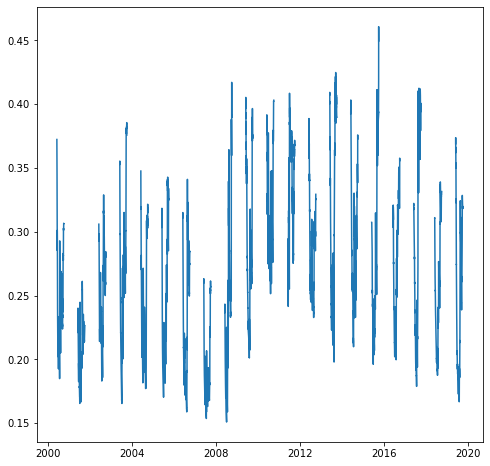

In [24]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)
    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

Mask = np.array([
    [1,1,1,1,1],
    [1,1,1,1,1],
    [0,0,1,1,0],
    [0,0,0,0,0],
    [0,0,0,0,0]])

Dir='Data/Subsurface/'
y = [-134.857734]
x = [69.386080]
Depth = [0,10,40,100]
# plt.figure()
for d,depth in enumerate(Depth):
    print(d)
    for i,dsname in enumerate(os.listdir(Dir)):
        if dsname!='.ipynb_checkpoints':
            print(dsname)
            fh = Dataset(Dir+dsname, mode='r')
            time=fh.variables['time'][:]
            lons = fh.variables['lon'][:][Mask==1]#[2:3,2:4]
            lats = fh.variables['lat'][:][Mask==1]#[2:3,2:4]
            var = dsname.split('.')[0]
            query = fh.variables[var][:][:,:,Mask==1]
            
#             print(query[0,0,:,:])
            if var == 'tsoil':
                query-=273.15
            fh.close()
            idw = np.array([
                simple_idw(
                    lons.flatten(),
                    lats.flatten(),
                    Q.flatten(),
                    np.array(y),
                    np.array(x)) for Q in query[:,d,:]]).flatten()
#             print(idw)
            if i+d == 0:
                Data = pd.DataFrame(data={var+'_'+str(depth):idw},
                                index=datetime(1800,1,1)+timedelta(hours=1)*time-timedelta(hours=0))
            else:
                Data = Data.append(pd.DataFrame(data={var+'_'+str(depth):idw},
                                index=datetime(1800,1,1)+timedelta(hours=1)*time-timedelta(hours=0)))

# print(query.shape)
            
Dir='Data/Surface/'
for i,dsname in enumerate(os.listdir(Dir)):
    if dsname!='.ipynb_checkpoints':
        print(dsname)
        fh = Dataset(Dir+dsname, mode='r')
        time=fh.variables['time'][:]
        lons = fh.variables['lon'][2:4,2:4]
        lats = fh.variables['lat'][2:4,2:4]
        var = dsname.split('.')[0]
        query = fh.variables[var][:,2:4,2:4]
#         print(query.shape)
        if var == 'air':
            query-=273.15
        fh.close()
#         idw=np.array([Q[2,2] for Q in query]).flatten()
        idw = np.array([
            simple_idw(
                lons.flatten(),
                lats.flatten(),
                Q.flatten(),
                np.array(y),
                np.array(x)) for Q in query]).flatten()
#         print(idw)
        if i == -1:
            Data = pd.DataFrame(data={var:idw},
                            index=datetime(1800,1,1)+timedelta(hours=1)*time-timedelta(hours=0))
        else:
            Data = Data.append(pd.DataFrame(data={var:idw},
                            index=datetime(1800,1,1)+timedelta(hours=1)*time-timedelta(hours=0)))

Data=Data.groupby(Data.index).mean()

Data['Wind_Speed'] = (Data['uwnd']**2+Data['vwnd']**2)**.5

Data['Wind_Dir'] = 180+180/np.pi*np.arctan2(Data['vwnd'],Data['uwnd'])

plt.figure(figsize=(8,8))
plt.plot(Data.index,Data['soilw_0'])


Data.to_csv('NARRData.csv')

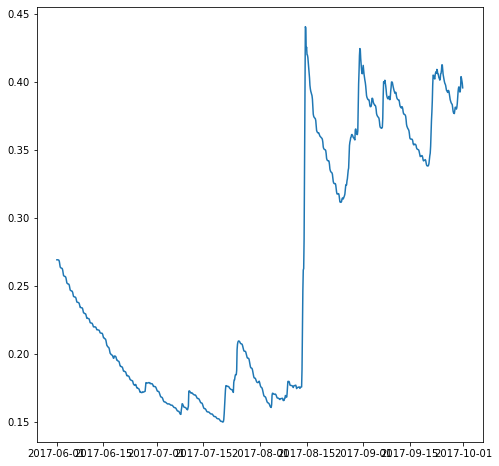

In [79]:
# print(Data[['soilw_10','tsoil_0']])##.sort_values())
# # plt.figure(figsize=(8,8))
# # plt.plot(Data.index,Data['soilw_10'])

Data=Data.groupby(Data.index).mean()
# print(Data2['soilw_0'])
# plt.figure()
# plt.scatter(Data['tsoil_10'],Data2['tsoil_10'])
plt.figure(figsize=(8,8))
plt.plot(Data.index,Data['soilw_0'])

In [18]:
#
import pytz

Mt = pytz.timezone('US/Mountain')
Data['MT'] = Data.index.tz_localize(pytz.utc).tz_convert(Mt)#.tz_localize(Mt)
print(Data['MT'].values)
print(Data.index.values)

# print(lats[2,2])
# print(lons[2,2])
# print()
# print(lats[2,3])
# print(lons[2,3])
# print(query[2,2])

['2000-01-01T00:00:00.000000000' '2000-01-01T03:00:00.000000000'
 '2000-01-01T06:00:00.000000000' ... '2020-10-31T15:00:00.000000000'
 '2020-10-31T18:00:00.000000000' '2020-10-31T21:00:00.000000000']
['2000-01-01T00:00:00.000000000' '2000-01-01T03:00:00.000000000'
 '2000-01-01T06:00:00.000000000' ... '2020-10-31T15:00:00.000000000'
 '2020-10-31T18:00:00.000000000' '2020-10-31T21:00:00.000000000']


# Grid Points

In [5]:
token = "pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2s4a285NTM1MDQwbDNocHozdXlkNzIyaSJ9.-_8gh9gG4VuprIPnmXBr3A" # your mapbox token
# tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

Map = folium.Map(
    location=[69.386080,-134.857734], zoom_start=9)#, tiles=tileurl, attr='Mapbox')

point=folium.CircleMarker(
        location=[69.386080,-134.857734],
        radius=10,
        popup='Fish Island',
        fill_opacity = 1,
        fill=True,
        color='black',
        line_weight=.35,
        fill_color='green'
).add_to(Map)

for lat,lon in zip(lats.flatten(),lons.flatten()):
    point=folium.CircleMarker(
            location=[lat,lon],
            radius=10,
            popup=str(lat)+' '+str(lon),
            fill_opacity = 1,
            fill=True,
            color='blue',
            line_weight=.35,
            fill_color='blue'
    ).add_to(Map)
Map

# Simple 2D Interpolation Methods

In [18]:

# )
# Mask = []
# Mask
# print(query.shape)
# print(query[:,:,Mask==1].shape)
# print(lats[Mask==1])
print(lats.shape)

(5, 5)
